In [1]:
import sys, os

# Add utility_scripts in the current path so that they can be imported directly just like in interactive mode
sys.path.append(os.path.abspath("../usr/lib/"))
for script_folder in os.listdir("../usr/lib/"):
    sys.path.append(os.path.abspath("../usr/lib/"+script_folder))

In [2]:
from statistics import mean

import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from lastquerytransformer import Riiid
from riiidutils import RiiidDataset, riiid_collate_fn

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Introduction

Le fichier train.csv comprend un peu plus de 100 millions de lignes.  
Il y a un peu moins de 400 mille user_id uniques.  
Le modèle utilisé dans ce notebook prend en entrée une série par utilisateur.

# Features utilisées
Pour chaque question de la série d'apprentissage d'un utilisateur quelconque  

1. Question ID: correspond à content_id (lorsque l'élément est une question).
2. Question part: correspond à part dans question.csv pour l'élément dont question_id correspondant à content_id
3. Answer correctness: valeur de answered_correctly de l'exemple (ou target encoding de la question ?)
4. Current question elapsed time: prior question de la question suivante.
5. Timestamp difference: current question timestamp - timestamp of the last question from the same user

# Chargement des données

In [4]:
questions_df = pd.read_csv('../input/riiid-test-answer-prediction/questions.csv', usecols=[0, 3])
questions_df[:5]

,question_id,part
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


In [5]:
data_types_dict={
    #'row_id': 'int64',
    'timestamp': 'int64',
    'user_id': 'int32',
    'content_id': 'int16',
    'content_type_id': 'int8',
    #'task_container_id': 'int16',
    #'user_answer': 'int8',
    'answered_correctly': 'int8',
    'prior_question_elapsed_time': 'float32', 
    #'prior_question_had_explanation': 'boolean',
    }

In [6]:
train = pd.read_csv('../input/riiid-test-answer-prediction/train.csv', usecols=data_types_dict.keys(), dtype=data_types_dict)[:10_000_000]#, skipfooter=90_000_000)
# skipfooter forces the use of the python engine which is much slower and too slow for this file.

In [7]:
train[:5]

,timestamp,user_id,content_id,content_type_id,answered_correctly,prior_question_elapsed_time
0,0,115,5692,0,1,NaN
1,56943,115,5716,0,1,37000.0
2,118363,115,128,0,1,55000.0
3,131167,115,7860,0,1,19000.0
4,137965,115,7922,0,1,11000.0


In [8]:
train = train[train.content_type_id == 0].drop('content_type_id', axis=1)
train = train.merge(questions_df, left_on="content_id", right_on="question_id").drop('content_id', axis=1)
train.sort_values(['user_id', 'timestamp'], inplace=True)

In [9]:
train[:5]

,timestamp,user_id,answered_correctly,prior_question_elapsed_time,question_id,part
0,0,115,1,NaN,5692,5
3548,56943,115,1,37000.0,5716,5
5924,118363,115,1,55000.0,128,1
7838,131167,115,1,19000.0,7860,1
9975,137965,115,1,11000.0,7922,1


# Construction des entrées et sorties

In [10]:
# to do before adding 1 to the answered_correctly column because I use BCEWithLogitsLoss which requires the targets to be between 0 and 1
users_y = train.groupby('user_id').tail(1)['answered_correctly'].values
users_y

array([1, 0, 1, ..., 1, 0, 1], dtype=int8)

In [11]:
train.min() # on vérifie que le min est proche de 0 afin de ne pas perdre de place dans nn.embedding où les vecteurs sont alloués à partir de l'index 0

timestamp                        0.0
user_id                        115.0
answered_correctly               0.0
prior_question_elapsed_time      0.0
question_id                      0.0
part                             1.0
dtype: float64

In [12]:
train['answered_correctly'] = train['answered_correctly']+1 # Incorrect answer becomes 1 and correct 2 to let 0 be used for padding
train['question_id'] = train['question_id'] + 1 # so that 0 can be used for padding

We offset the output embeddings by one position to make sure that predictions for position $i$ can depend only on the known features at position less than $i$: 'answered_correctly' now means 'last question answered_correctly'. Look ahead mask is not required because we only predict the last answer's correctness.

In [13]:
train['answered_correctly'] = train.groupby('user_id')['answered_correctly'].shift(fill_value=3) # 3 is ≃ <sos> token

We offset 'prior_question_elapsed_time' by one position to get 'current_question_elapsed_time'

In [14]:
train['current_question_elapsed_time'] = train.groupby('user_id')['prior_question_elapsed_time'].shift(-1, fill_value=0) # 0 is ≃ <eos> token

Timestamp_diff is the difference from the past question timestamp to the current question timestamp clipped by a maximum value of 3 days (2,592×10⁵ seconds)

In [15]:
train['timestamp_diff'] = train.groupby('user_id')['timestamp'].diff().fillna(0)
train['timestamp_diff'].clip(lower=None, upper=2.592*1e5, inplace=True)

In [16]:
train = train[['user_id', 'question_id', 'part', 'answered_correctly', 'current_question_elapsed_time', 'timestamp_diff']]

In [17]:
maximums = dict(train[['question_id', 'part', 'answered_correctly']].max())
maximums

{'question_id': 13523, 'part': 7, 'answered_correctly': 3}

In [18]:
train.dtypes # on vérifie que les variables catégorielles ont bien le type int

user_id                            int32
question_id                        int64
part                               int64
answered_correctly                  int8
current_question_elapsed_time    float32
timestamp_diff                   float64
dtype: object

## Batches
Dynamic Padding: ajout de padding batch par batch pour avoir une même longueur de séquence dans chaque batch.  
Uniform size batching: on trie les utilisateurs par longueur de séquence, afin d'avoir des longueurs plus proches dans chaque batch  

Afin de mettre en œuvre ces deux stratégies on va par simplicité trier au préalable et conjointement les listes batch_cat, batch_cont et batch_y par longueur des séquences dans batch_cat/batch_cont (c'est RiiidDataset qui s'en charge). Le DataLoader utilisera une fonction collate_fn permettant d'ajouter du padding dynamiquement batch par batch.

In [19]:
#batch = [x.drop('user_id', axis=1).values for _, x in train.groupby('user_id')]
users_cat = [x[['question_id', 'part', 'answered_correctly']].values for _, x in train.groupby('user_id')]
users_cont = [x[['current_question_elapsed_time', 'timestamp_diff']].values for _, x in train.groupby('user_id')]

In [20]:
cat_train, cat_val, cont_train, cont_val, y_train, y_val = train_test_split(users_cat, users_cont, users_y, test_size=.05)

In [21]:
train_dataset = RiiidDataset(cat_train, cont_train, y_train)
val_dataset = RiiidDataset(cat_val, cont_val, y_val)

In [22]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=False, collate_fn=riiid_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=riiid_collate_fn)

# Modèle
Pour le modèle, l'auteur s'est inspiré de la solution arrivée 3è à la compétition [Data Science bowl 2019](https://www.kaggle.com/c/data-science-bowl-2019/discussion/127891)  
La procédure de création des embeddings est expliquée, on suppose que l'auteur s'est basé dessus.
## Embeddings
On utilise un embedding catégoriel pour les 3 premières variables et un embedding continu pour les 2 dernières.
Contrairement à la solution du lien ci-dessus on utilise un embedding catégoriel par variable catégorielle plutôt qu'un embedding commun, comme recommandé [ici](https://discuss.pytorch.org/t/categorical-embeddings-can-i-only-have-1-categorical-column-per-embedding-layer/104681/3)

In [23]:
model = Riiid(maximums).to(device)

# Training

In [24]:
LEARNING_RATE = 1e-6
criterion = nn.BCEWithLogitsLoss()
#criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [25]:
def evaluate(model, iterator, criterion):
    model.eval()
    losses = []
    accuracies = []
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            x_cat = batch['cat'].to(device)
            x_cont = batch['cont'].to(device)
            y = batch['y'].to(device)

            ypred = model(x_cat, x_cont).squeeze(0)
            loss = criterion(ypred, y)

            losses.append(float(loss))
            accuracies.append((torch.round(torch.sigmoid(ypred)) == y).float().mean().item())

    return mean(losses), mean(accuracies)

In [26]:
accuracies = []
losses = []
val_accuracies = []
val_losses = []

In [27]:
epochs = 50
# we use 2 writers so we can have the train and val scalars on the same plots
train_writer = SummaryWriter(os.path.join(LOG_DIR, "train"))
val_writer = SummaryWriter(os.path.join(LOG_DIR, "val"))

for e in range(epochs):
    model.train()
    e_accuracies = []
    e_losses = []
    print("Epoch ", e)
    for batch in train_loader:
        x_cat = batch['cat'].to(device)
        x_cont = batch['cont'].to(device)
        y = batch['y'].to(device)

        ypred = model(x_cat, x_cont).squeeze(0)
        loss = criterion(ypred, y)
        with torch.no_grad():
            e_losses.append(float(loss))
            e_accuracies.append((torch.round(torch.sigmoid(ypred)) == y).float().mean().item())

        loss.backward()
        optimizer.step()
    losses.append(mean(e_losses))
    accuracies.append(mean(e_accuracies))
    val_l, val_acc = evaluate(model, val_loader, criterion)
    val_accuracies.append(val_acc)
    val_losses.append(val_l)
    print("Loss:", losses[-1])
    print("Accuracy:", accuracies[-1])
    print("Validation loss:", val_losses[-1])
    print("Validation accuracy:", val_accuracies[-1])
    train_writer.add_scalar("Loss", losses[-1], e)
    train_writer.add_scalar("Accuracy", accuracies[-1], e)
    val_writer.add_scalar("Loss", val_losses[-1], e)
    val_writer.add_scalar("Accuracy", val_accuracies[-1], e)

train_writer.close()
val_writer.close()

Epoch  0


RuntimeError: CUDA out of memory. Tried to allocate 974.00 MiB (GPU 0; 3.95 GiB total capacity; 2.31 GiB already allocated; 935.00 MiB free; 2.40 GiB reserved in total by PyTorch)

Plots du premier brouillon n'utilisant pas toutes les features du gagnant, sur 100 exemples

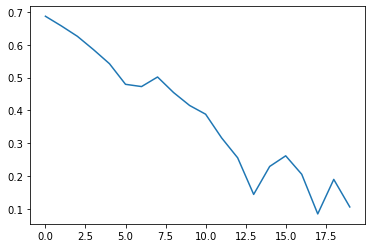

In [32]:
plt.plot(losses)

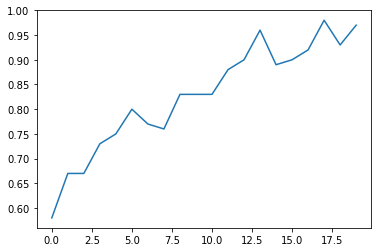

In [34]:
plt.plot(accuracies)

Plots du second brouillon, utilisant toutes les features du gagnant, sur 100 exemples

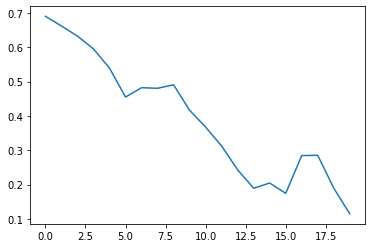

In [95]:
plt.plot(losses)

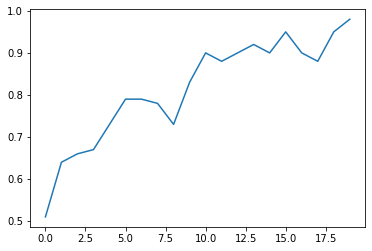

In [96]:
plt.plot(accuracies)

Plot de la version vectorisée, sur 380 exemples

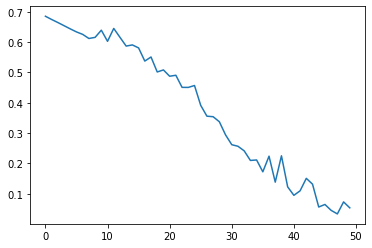

In [31]:
plt.plot(losses)

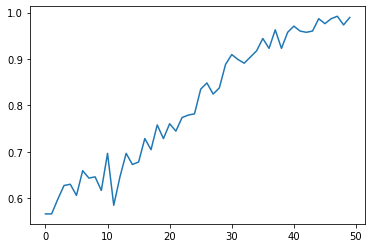

In [32]:
plt.plot(accuracies)

Plot de la version vectorisée, sur 3800 exemples (1% du dataset total)

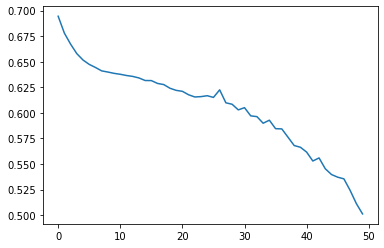

In [38]:
plt.plot(losses)

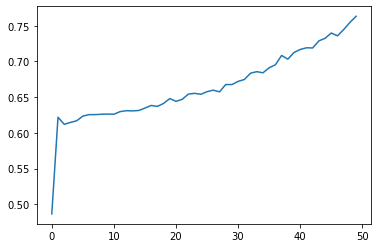

In [39]:
plt.plot(accuracies)

Plot de la version vectorisée avec dataloader et train val split, sur 3800 exemples (1% du dataset total)

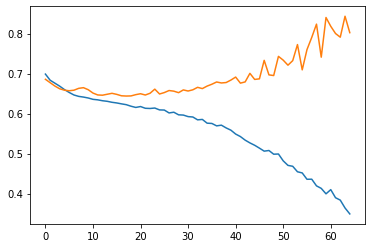

In [33]:
plt.plot(losses)
plt.plot(val_losses)

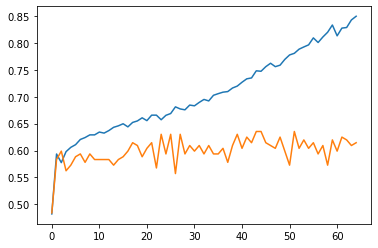

In [34]:
plt.plot(accuracies)
plt.plot(val_accuracies)